DEKOIS

split

In [ ]:
import os
from rdkit.Chem import PandasTools
from sklearn.model_selection import train_test_split

directory = "/home/alacournola/DEKOIS_2.0x"
sdf_files = []

# Walk through the directory to find all SDF files
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith("docking_library.sdf"):  # Ensures it's an SDF file
            sdf_files.append(os.path.join(root, file))

# Load each SDF file, split into training and test sets, and write them back as SDF files
for sdf_file in sdf_files:
    dataframe = PandasTools.LoadSDF(sdf_file, idName="ID", molColName="Molecule")
    dataframe["Activity"] = dataframe["Activity"].astype(float).astype(int)

    train_df_50, test_df_50 = train_test_split(
        dataframe, test_size=0.5, stratify=dataframe["Activity"], random_state=42
    )
    train_df_30, test_df_70 = train_test_split(
        dataframe, test_size=0.3, stratify=dataframe["Activity"], random_state=42
    )
    # Define the file paths for the train and test SDF files
    train_file_path_50 = os.path.join(os.path.dirname(sdf_file), "train_50.sdf")
    test_file_path_50 = os.path.join(os.path.dirname(sdf_file), "test_50.sdf")
    train_file_path_30 = os.path.join(os.path.dirname(sdf_file), "train_30.sdf")
    test_file_path_70 = os.path.join(os.path.dirname(sdf_file), "test_70.sdf")
    # Write the training and testing DataFrames to SDF files
    PandasTools.WriteSDF(
        train_df_50, train_file_path_50, molColName="Molecule", idName="ID", properties=list(train_df_50.columns)
    )
    PandasTools.WriteSDF(
        test_df_50, test_file_path_50, molColName="Molecule", idName="ID", properties=list(test_df_50.columns)
    )
    PandasTools.WriteSDF(
        train_df_30, train_file_path_30, molColName="Molecule", idName="ID", properties=list(train_df_30.columns)
    )
    PandasTools.WriteSDF(
        test_df_70, test_file_path_70, molColName="Molecule", idName="ID", properties=list(test_df_70.columns)
    )
    print(f"Written training set to {train_file_path_50}")
    print(f"Written test set to {test_file_path_50}")

50

In [ ]:
from scripts.library_preparation import *
from scripts.utilities import *
from scripts.docking_functions import *
from scripts.clustering_functions import *
from scripts.rescoring_functions import *
from scripts.consensus_methods import *
from scripts.performance_calculation import *
from scripts.dogsitescorer import *
from scripts.get_pocket import *
from scripts.postprocessing import *
from scripts.protein_preparation import *

In [ ]:
def calculate_performance(w_dir: Path, actives_library: Path, percentages: list):
    """
    Calculates the performance of a scoring system for different clustering methods.

    Args:
        w_dir (Path): The directory path where the scoring results are stored.
        actives_library (Path): The path to the actives library in SDF format.
        percentages (list): A list of percentages for calculating the EF (enrichment factor).

    Returns:
        DataFrame: A DataFrame containing the performance results for different clustering methods, consensus methods, and scoring functions.
    """
    printlog("Calculating performance...")
    # all_results = pd.DataFrame(columns=['clustering', 'consensus', 'scoring'] + [f'EF{p}' for p in percentages])
    # Load actives data
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName="ID")
    actives_df = actives_df[["ID", "Activity"]]
    actives_df["Activity"] = pd.to_numeric(actives_df["Activity"])
    # Calculate performance for each clustering method
    dirs = [dir for dir in os.listdir(w_dir) if dir.startswith("rescoring") and dir.endswith("clustered")]
    results = parallel_executor(
        calculate_performance_for_clustering_method,
        dirs,
        ncpus=math.ceil(len(dirs) // 2),
        backend="concurrent_process_silent",
        w_dir=w_dir,
        actives_df=actives_df,
        percentages=percentages,
    )
    all_results = pd.concat(results, ignore_index=True)
    (w_dir / "performance").mkdir(parents=True, exist_ok=True)
    all_results.to_csv(Path(w_dir) / "performance" / "performance_50.csv", index=False)
    return all_results

In [ ]:
def determine_performance(target_dir):
    # for target_dir in tqdm(sorted(os.listdir('/home/alacournola/DEKOIS_2.0x'))):
    try:
        calculate_performance(
            Path(f"/home/alacournola/DEKOIS_2.0x/{target_dir}/{target_dir}_p_protoss"),
            f"/home/alacournola/DEKOIS_2.0x/{target_dir}/train_50.sdf",
            [0.5, 1, 5],
        )
    except:
        print(target_dir, "FAILED")
        print(traceback.format_exc())


dirs = [dir for dir in sorted(os.listdir("/home/alacournola/DEKOIS_2.0x"))]

parallel_executor(determine_performance, dirs, ncpus=4, backend="concurrent_process_silent")

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import traceback

data = pd.DataFrame(columns=["pdb_id", "model", "AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"])

for target_dir in tqdm(os.listdir("/home/alacournola/DEKOIS_2.0x/")):
    try:
        performance = pd.read_csv(
            f"/home/alacournola/DEKOIS_2.0x/{target_dir}/{target_dir}_p_protoss/performance/performance_50.csv"
        )

        # Extract relevant data
        pdb_id = target_dir
        model = "DockM8-max"
        performance = performance.sort_values(by="AUC_ROC", ascending=False)
        auc_roc = performance.iloc[0]["AUC_ROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="BEDROC", ascending=False)
        bedroc = performance.iloc[0]["BEDROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="AUC", ascending=False)
        auc = performance.iloc[0]["AUC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="RIE", ascending=False)
        rie = performance.iloc[0]["RIE"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_0.5%", ascending=False)
        ef_05 = performance.iloc[0]["EF_0.5%"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_1%", ascending=False)
        ef_1 = performance.iloc[0]["EF_1%"] if len(performance) > 0 else None
        best_model_clustering = performance.iloc[0]["clustering"] if len(performance) > 0 else None
        best_model_consensus = performance.iloc[0]["consensus"] if len(performance) > 0 else None
        best_model_scoring = performance.iloc[0]["scoring"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_5%", ascending=False)
        ef_5 = performance.iloc[0]["EF_5%"] if len(performance) > 0 else None

        extracted_data = pd.DataFrame(
            [
                {
                    "pdb_id": target_dir,
                    "model": "DockM8-max",
                    "AUC_ROC": round(auc_roc, 3),
                    "BEDROC": round(bedroc, 3),
                    "AUC": round(auc, 3),
                    "RIE": round(rie, 3),
                    "EF_0.5%": round(ef_05, 3),
                    "EF_1%": round(ef_1, 3),
                    "EF_5%": round(ef_5, 3),
                    "best_clustering_EF1": best_model_clustering,
                    "best_consensus_EF1": best_model_consensus,
                    "best_scoring_EF1": best_model_scoring,
                }
            ]
        )

        data = pd.concat([data, extracted_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing {target_dir}: {e}")
        print(traceback.format_exc())
# Optionally, you can reset the index of the DataFrame
data = data.reset_index(drop=True)

display(data)

data.to_csv("/home/alacournola/DEKOIS_2.0x/DEKOIS_RESULTS/results_dockm8_max_50.csv", index=False)

In [ ]:
from tqdm import tqdm
import os
import pandas as pd
import traceback

metrics = ["AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"]
base_dir = "/home/alacournola/DEKOIS_2.0x"


# for metric in tqdm(metrics):
def process_metric(metric):
    final = None
    for target_dir in sorted(os.listdir(base_dir)):
        file_path = os.path.join(base_dir, target_dir, f"{target_dir}_p_protoss/performance/performance_50.csv")
        try:
            with open(file_path, "r") as file:
                performance = pd.read_csv(file)
                performance = performance.sort_values(by=metric, ascending=False)
                performance = performance[["clustering", "consensus", "scoring", metric]]
                performance[metric] = performance[metric].round(3)
                performance = performance.rename(columns={metric: target_dir})
                if final is None:
                    final = performance
                else:
                    final = pd.merge(final, performance, on=["clustering", "consensus", "scoring"], how="outer")
        except Exception as e:
            print(f"Error processing {target_dir}: {e}")
            traceback.print_exc()

    if final is not None:
        final.to_csv(os.path.join(base_dir, "DEKOIS_RESULTS", f"results_dockm8_{metric}_50.csv"), index=False)


parallel_executor(process_metric, metrics, 8)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Load the enrichment factor data
ef_50_path = "/home/alacournola/DEKOIS_2.0x/DEKOIS_RESULTS/results_dockm8_EF_1%_50.csv"
ef_full_path = "/home/alacournola/DEKOIS_2.0x/DEKOIS_RESULTS/results_dockm8_EF_1%.csv"

ef_50_df = pd.read_csv(ef_50_path)
ef_full_df = pd.read_csv(ef_full_path)

# Assuming the first three columns are 'clustering', 'consensus', and 'scoring', and the rest are targets
targets = ef_50_df.columns[3:]

# Store Spearman correlations
spearman_correlations_50 = {}

for target in targets:
    # Rank the methods based on their EF values for this target
    ef_50_df["rank_50"] = ef_50_df[target].rank(method="average", ascending=False)
    ef_full_df["rank_full"] = ef_full_df[target].rank(method="average", ascending=False)

    # Merge the ranks based on the method description (assuming a consistent unique identifier exists)
    merged_ranks = pd.merge(
        ef_50_df[["clustering", "consensus", "scoring", "rank_50"]],
        ef_full_df[["clustering", "consensus", "scoring", "rank_full"]],
        on=["clustering", "consensus", "scoring"],
    )

    # Calculate Spearman's rank correlation for this target
    spearman_corr, _ = spearmanr(merged_ranks["rank_50"], merged_ranks["rank_full"])
    spearman_correlations_50[target] = spearman_corr

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spearman correlations dictionary to a DataFrame for easier plotting
spearman_df_50 = pd.DataFrame(list(spearman_correlations_50.items()), columns=["Target", "Spearman Correlation"])

# Sort the DataFrame by Spearman Correlation for a more informative plot
spearman_df_50 = spearman_df_50.sort_values(by="Spearman Correlation", ascending=False)

# Create a bar plot
plt.figure(figsize=(5, 12))
sns.barplot(x="Spearman Correlation", y="Target", data=spearman_df_50, palette="coolwarm")
plt.title("Spearman Rank Correlation of DockM8-Methods Across Targets")
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Target")
plt.grid(axis="x")

# Show the plot
plt.show()

30

In [ ]:
def calculate_performance(w_dir: Path, actives_library: Path, percentages: list):
    """
    Calculates the performance of a scoring system for different clustering methods.

    Args:
        w_dir (Path): The directory path where the scoring results are stored.
        actives_library (Path): The path to the actives library in SDF format.
        percentages (list): A list of percentages for calculating the EF (enrichment factor).

    Returns:
        DataFrame: A DataFrame containing the performance results for different clustering methods, consensus methods, and scoring functions.
    """
    printlog("Calculating performance...")
    # all_results = pd.DataFrame(columns=['clustering', 'consensus', 'scoring'] + [f'EF{p}' for p in percentages])
    # Load actives data
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName="ID")
    actives_df = actives_df[["ID", "Activity"]]
    actives_df["Activity"] = pd.to_numeric(actives_df["Activity"])
    # Calculate performance for each clustering method
    dirs = [dir for dir in os.listdir(w_dir) if dir.startswith("rescoring") and dir.endswith("clustered")]
    results = parallel_executor(
        calculate_performance_for_clustering_method,
        dirs,
        ncpus=math.ceil(len(dirs) // 2),
        backend="concurrent_process_silent",
        w_dir=w_dir,
        actives_df=actives_df,
        percentages=percentages,
    )
    all_results = pd.concat(results, ignore_index=True)
    (w_dir / "performance").mkdir(parents=True, exist_ok=True)
    all_results.to_csv(Path(w_dir) / "performance" / "performance_30.csv", index=False)
    return all_results

In [ ]:
def determine_performance(target_dir):
    # for target_dir in tqdm(sorted(os.listdir('/home/alacournola/DEKOIS_2.0x'))):
    try:
        calculate_performance(
            Path(f"/home/alacournola/DEKOIS_2.0x/{target_dir}/{target_dir}_p_protoss"),
            f"/home/alacournola/DEKOIS_2.0x/{target_dir}/train_30.sdf",
            [0.5, 1, 5],
        )
    except:
        print(target_dir, "FAILED")
        print(traceback.format_exc())


dirs = [dir for dir in sorted(os.listdir("/home/alacournola/DEKOIS_2.0x"))]

parallel_executor(determine_performance, dirs, ncpus=4, backend="concurrent_process_silent")

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import traceback

data = pd.DataFrame(columns=["pdb_id", "model", "AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"])

for target_dir in tqdm(os.listdir("/home/alacournola/DEKOIS_2.0x/")):
    try:
        performance = pd.read_csv(
            f"/home/alacournola/DEKOIS_2.0x/{target_dir}/{target_dir}_p_protoss/performance/performance_30.csv"
        )

        # Extract relevant data
        pdb_id = target_dir
        model = "DockM8-max"
        performance = performance.sort_values(by="AUC_ROC", ascending=False)
        auc_roc = performance.iloc[0]["AUC_ROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="BEDROC", ascending=False)
        bedroc = performance.iloc[0]["BEDROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="AUC", ascending=False)
        auc = performance.iloc[0]["AUC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="RIE", ascending=False)
        rie = performance.iloc[0]["RIE"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_0.5%", ascending=False)
        ef_05 = performance.iloc[0]["EF_0.5%"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_1%", ascending=False)
        ef_1 = performance.iloc[0]["EF_1%"] if len(performance) > 0 else None
        best_model_clustering = performance.iloc[0]["clustering"] if len(performance) > 0 else None
        best_model_consensus = performance.iloc[0]["consensus"] if len(performance) > 0 else None
        best_model_scoring = performance.iloc[0]["scoring"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_5%", ascending=False)
        ef_5 = performance.iloc[0]["EF_5%"] if len(performance) > 0 else None

        extracted_data = pd.DataFrame(
            [
                {
                    "pdb_id": target_dir,
                    "model": "DockM8-max",
                    "AUC_ROC": round(auc_roc, 3),
                    "BEDROC": round(bedroc, 3),
                    "AUC": round(auc, 3),
                    "RIE": round(rie, 3),
                    "EF_0.5%": round(ef_05, 3),
                    "EF_1%": round(ef_1, 3),
                    "EF_5%": round(ef_5, 3),
                    "best_clustering_EF1": best_model_clustering,
                    "best_consensus_EF1": best_model_consensus,
                    "best_scoring_EF1": best_model_scoring,
                }
            ]
        )

        data = pd.concat([data, extracted_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing {target_dir}: {e}")
        print(traceback.format_exc())
# Optionally, you can reset the index of the DataFrame
data = data.reset_index(drop=True)

display(data)

data.to_csv("/home/alacournola/DEKOIS_2.0x/DEKOIS_RESULTS/results_dockm8_max_30.csv", index=False)

In [ ]:
from tqdm import tqdm
import os
import pandas as pd
import traceback

metrics = ["AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"]
base_dir = "/home/alacournola/DEKOIS_2.0x"


# for metric in tqdm(metrics):
def process_metric(metric):
    final = None
    for target_dir in sorted(os.listdir(base_dir)):
        file_path = os.path.join(base_dir, target_dir, f"{target_dir}_p_protoss/performance/performance_30.csv")
        try:
            with open(file_path, "r") as file:
                performance = pd.read_csv(file)
                performance = performance.sort_values(by=metric, ascending=False)
                performance = performance[["clustering", "consensus", "scoring", metric]]
                performance[metric] = performance[metric].round(3)
                performance = performance.rename(columns={metric: target_dir})
                if final is None:
                    final = performance
                else:
                    final = pd.merge(final, performance, on=["clustering", "consensus", "scoring"], how="outer")
        except Exception as e:
            print(f"Error processing {target_dir}: {e}")
            traceback.print_exc()

    if final is not None:
        final.to_csv(os.path.join(base_dir, "DEKOIS_RESULTS", f"results_dockm8_{metric}_30.csv"), index=False)


parallel_executor(process_metric, metrics, 8)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Load the enrichment factor data
ef_30_path = "/home/alacournola/DEKOIS_2.0x/DEKOIS_RESULTS/results_dockm8_EF_1%_30.csv"
ef_full_path = "/home/alacournola/DEKOIS_2.0x/DEKOIS_RESULTS/results_dockm8_EF_1%.csv"

ef_30_df = pd.read_csv(ef_30_path)
ef_full_df = pd.read_csv(ef_full_path)

# Assuming the first three columns are 'clustering', 'consensus', and 'scoring', and the rest are targets
targets = ef_30_df.columns[3:]

# Store Spearman correlations
spearman_correlations_30 = {}

for target in targets:
    # Rank the methods based on their EF values for this target
    ef_30_df["rank_30"] = ef_30_df[target].rank(method="average", ascending=False)
    ef_full_df["rank_full"] = ef_full_df[target].rank(method="average", ascending=False)

    # Merge the ranks based on the method description (assuming a consistent unique identifier exists)
    merged_ranks = pd.merge(
        ef_30_df[["clustering", "consensus", "scoring", "rank_30"]],
        ef_full_df[["clustering", "consensus", "scoring", "rank_full"]],
        on=["clustering", "consensus", "scoring"],
    )

    # Calculate Spearman's rank correlation for this target
    spearman_corr, _ = spearmanr(merged_ranks["rank_30"], merged_ranks["rank_full"])
    spearman_correlations_30[target] = spearman_corr

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spearman correlations dictionary to a DataFrame for easier plotting
spearman_df_30 = pd.DataFrame(list(spearman_correlations_30.items()), columns=["Target", "Spearman Correlation"])

# Sort the DataFrame by Spearman Correlation for a more informative plot
spearman_df_30 = spearman_df_30.sort_values(by="Spearman Correlation", ascending=False)

# Create a bar plot
plt.figure(figsize=(5, 12))
sns.barplot(x="Spearman Correlation", y="Target", data=spearman_df_30, palette="coolwarm")
plt.title("Spearman Rank Correlation of DockM8-Methods Across Targets")
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Target")
plt.grid(axis="x")

# Show the plot
plt.show()

DUDE

split

In [ ]:
import os
from rdkit.Chem import PandasTools
from sklearn.model_selection import train_test_split

directory = "/home/alacournola/DUD-E"
sdf_files = []

# Walk through the directory to find all SDF files
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith("merged_actives_decoys.sdf"):  # Ensures it's an SDF file
            sdf_files.append(os.path.join(root, file))

# Load each SDF file, split into training and test sets, and write them back as SDF files
for sdf_file in sdf_files:
    dataframe = PandasTools.LoadSDF(sdf_file, idName="ID", molColName="Molecule")
    dataframe["Activity"] = dataframe["Activity"].astype(float).astype(int)

    train_df_50, test_df_50 = train_test_split(
        dataframe, test_size=0.5, stratify=dataframe["Activity"], random_state=42
    )
    train_df_30, test_df_70 = train_test_split(
        dataframe, test_size=0.3, stratify=dataframe["Activity"], random_state=42
    )
    # Define the file paths for the train and test SDF files
    train_file_path_50 = os.path.join(os.path.dirname(sdf_file), "train_50.sdf")
    test_file_path_50 = os.path.join(os.path.dirname(sdf_file), "test_50.sdf")
    train_file_path_30 = os.path.join(os.path.dirname(sdf_file), "train_30.sdf")
    test_file_path_70 = os.path.join(os.path.dirname(sdf_file), "test_70.sdf")
    # Write the training and testing DataFrames to SDF files
    PandasTools.WriteSDF(
        train_df_50, train_file_path_50, molColName="Molecule", idName="ID", properties=list(train_df_50.columns)
    )
    PandasTools.WriteSDF(
        test_df_50, test_file_path_50, molColName="Molecule", idName="ID", properties=list(test_df_50.columns)
    )
    PandasTools.WriteSDF(
        train_df_30, train_file_path_30, molColName="Molecule", idName="ID", properties=list(train_df_30.columns)
    )
    PandasTools.WriteSDF(
        test_df_70, test_file_path_70, molColName="Molecule", idName="ID", properties=list(test_df_70.columns)
    )
    print(f"Written training set to {train_file_path_50}")
    print(f"Written test set to {test_file_path_50}")

50

In [ ]:
from scripts.library_preparation import *
from scripts.utilities import *
from scripts.docking_functions import *
from scripts.clustering_functions import *
from scripts.rescoring_functions import *
from scripts.consensus_methods import *
from scripts.performance_calculation import *
from scripts.dogsitescorer import *
from scripts.get_pocket import *
from scripts.postprocessing import *
from scripts.protein_preparation import *

In [ ]:
def calculate_performance(w_dir: Path, actives_library: Path, percentages: list):
    """
    Calculates the performance of a scoring system for different clustering methods.

    Args:
        w_dir (Path): The directory path where the scoring results are stored.
        actives_library (Path): The path to the actives library in SDF format.
        percentages (list): A list of percentages for calculating the EF (enrichment factor).

    Returns:
        DataFrame: A DataFrame containing the performance results for different clustering methods, consensus methods, and scoring functions.
    """
    printlog("Calculating performance...")
    # all_results = pd.DataFrame(columns=['clustering', 'consensus', 'scoring'] + [f'EF{p}' for p in percentages])
    # Load actives data
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName="ID")
    actives_df = actives_df[["ID", "Activity"]]
    actives_df["Activity"] = pd.to_numeric(actives_df["Activity"])
    # Calculate performance for each clustering method
    dirs = [dir for dir in os.listdir(w_dir) if dir.startswith("rescoring") and dir.endswith("clustered")]
    results = parallel_executor(
        calculate_performance_for_clustering_method,
        dirs,
        ncpus=math.ceil(len(dirs) // 2),
        backend="concurrent_process_silent",
        w_dir=w_dir,
        actives_df=actives_df,
        percentages=percentages,
    )
    all_results = pd.concat(results, ignore_index=True)
    (w_dir / "performance").mkdir(parents=True, exist_ok=True)
    all_results.to_csv(Path(w_dir) / "performance" / "performance_50.csv", index=False)
    return all_results

In [ ]:
def determine_performance(target_dir):
    # for target_dir in tqdm(sorted(os.listdir('/home/alacournola/DEKOIS_2.0x'))):
    try:
        calculate_performance(
            Path(f"/home/alacournola/DUD-E/{target_dir}/receptor_protoss_prepared_protoss"),
            f"/home/alacournola/DUD-E/{target_dir}/train_50.sdf",
            [0.5, 1, 5],
        )
    except:
        print(target_dir, "FAILED")
        print(traceback.format_exc())


dirs = [dir for dir in sorted(os.listdir("/home/alacournola/DUD-E"))]

parallel_executor(determine_performance, dirs, ncpus=4, backend="concurrent_process_silent")

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import traceback

data = pd.DataFrame(columns=["pdb_id", "model", "AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"])

for target_dir in tqdm(os.listdir("/home/alacournola/DUD-E/")):
    try:
        performance = pd.read_csv(
            f"/home/alacournola/DUD-E/{target_dir}/receptor_protoss_prepared_protoss/performance/performance_50.csv"
        )

        # Extract relevant data
        pdb_id = target_dir
        model = "DockM8-max"
        performance = performance.sort_values(by="AUC_ROC", ascending=False)
        auc_roc = performance.iloc[0]["AUC_ROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="BEDROC", ascending=False)
        bedroc = performance.iloc[0]["BEDROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="AUC", ascending=False)
        auc = performance.iloc[0]["AUC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="RIE", ascending=False)
        rie = performance.iloc[0]["RIE"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_0.5%", ascending=False)
        ef_05 = performance.iloc[0]["EF_0.5%"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_1%", ascending=False)
        ef_1 = performance.iloc[0]["EF_1%"] if len(performance) > 0 else None
        best_model_clustering = performance.iloc[0]["clustering"] if len(performance) > 0 else None
        best_model_consensus = performance.iloc[0]["consensus"] if len(performance) > 0 else None
        best_model_scoring = performance.iloc[0]["scoring"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_5%", ascending=False)
        ef_5 = performance.iloc[0]["EF_5%"] if len(performance) > 0 else None

        extracted_data = pd.DataFrame(
            [
                {
                    "pdb_id": target_dir,
                    "model": "DockM8-max",
                    "AUC_ROC": round(auc_roc, 3),
                    "BEDROC": round(bedroc, 3),
                    "AUC": round(auc, 3),
                    "RIE": round(rie, 3),
                    "EF_0.5%": round(ef_05, 3),
                    "EF_1%": round(ef_1, 3),
                    "EF_5%": round(ef_5, 3),
                    "best_clustering_EF1": best_model_clustering,
                    "best_consensus_EF1": best_model_consensus,
                    "best_scoring_EF1": best_model_scoring,
                }
            ]
        )

        data = pd.concat([data, extracted_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing {target_dir}: {e}")
        print(traceback.format_exc())
# Optionally, you can reset the index of the DataFrame
data = data.reset_index(drop=True)

display(data)

data.to_csv("/home/alacournola/DUD-E/DUD-E_RESULTS/results_dockm8_max_50.csv", index=False)

In [ ]:
from tqdm import tqdm
import os
import pandas as pd
import traceback

metrics = ["AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"]
base_dir = "/home/alacournola/DUD-E"


# for metric in tqdm(metrics):
def process_metric(metric):
    final = None
    for target_dir in sorted(os.listdir(base_dir)):
        file_path = os.path.join(
            base_dir, f"{target_dir}/receptor_protoss_prepared_protoss/performance/performance_50.csv"
        )
        try:
            with open(file_path, "r") as file:
                performance = pd.read_csv(file)
                performance = performance.sort_values(by=metric, ascending=False)
                performance = performance[["clustering", "consensus", "scoring", metric]]
                performance[metric] = performance[metric].round(3)
                performance = performance.rename(columns={metric: target_dir})
                if final is None:
                    final = performance
                else:
                    final = pd.merge(final, performance, on=["clustering", "consensus", "scoring"], how="outer")
        except Exception as e:
            print(f"Error processing {target_dir}: {e}")
            traceback.print_exc()

    if final is not None:
        final.to_csv(os.path.join(base_dir, "DUD-E_RESULTS", f"results_dockm8_{metric}_50.csv"), index=False)


parallel_executor(process_metric, metrics, 8)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Load the enrichment factor data
ef_50_path = "/home/alacournola/DUD-E/DUD-E_RESULTS/results_dockm8_EF_1%_50.csv"
ef_full_path = "/home/alacournola/DUD-E/DUD-E_RESULTS/results_dockm8_EF_1%.csv"

ef_50_df = pd.read_csv(ef_50_path)
ef_full_df = pd.read_csv(ef_full_path)

# Assuming the first three columns are 'clustering', 'consensus', and 'scoring', and the rest are targets
targets = ef_50_df.columns[3:]

# Store Spearman correlations
spearman_correlations_50 = {}

for target in targets:
    # Rank the methods based on their EF values for this target
    ef_50_df["rank_50"] = ef_50_df[target].rank(method="average", ascending=False)
    ef_full_df["rank_full"] = ef_full_df[target].rank(method="average", ascending=False)

    # Merge the ranks based on the method description (assuming a consistent unique identifier exists)
    merged_ranks = pd.merge(
        ef_50_df[["clustering", "consensus", "scoring", "rank_50"]],
        ef_full_df[["clustering", "consensus", "scoring", "rank_full"]],
        on=["clustering", "consensus", "scoring"],
    )

    # Calculate Spearman's rank correlation for this target
    spearman_corr, _ = spearmanr(merged_ranks["rank_50"], merged_ranks["rank_full"])
    spearman_correlations_50[target] = spearman_corr

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spearman correlations dictionary to a DataFrame for easier plotting
spearman_df_50 = pd.DataFrame(list(spearman_correlations_50.items()), columns=["Target", "Spearman Correlation"])

# Sort the DataFrame by Spearman Correlation for a more informative plot
spearman_df_50 = spearman_df_50.sort_values(by="Spearman Correlation", ascending=False)

# Create a bar plot
plt.figure(figsize=(5, 12))
sns.barplot(x="Spearman Correlation", y="Target", data=spearman_df_50, palette="coolwarm")
plt.title("Spearman Rank Correlation of DockM8-Methods Across Targets")
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Target")
plt.grid(axis="x")

# Show the plot
plt.show()

30

In [ ]:
def calculate_performance(w_dir: Path, actives_library: Path, percentages: list):
    """
    Calculates the performance of a scoring system for different clustering methods.

    Args:
        w_dir (Path): The directory path where the scoring results are stored.
        actives_library (Path): The path to the actives library in SDF format.
        percentages (list): A list of percentages for calculating the EF (enrichment factor).

    Returns:
        DataFrame: A DataFrame containing the performance results for different clustering methods, consensus methods, and scoring functions.
    """
    printlog("Calculating performance...")
    # all_results = pd.DataFrame(columns=['clustering', 'consensus', 'scoring'] + [f'EF{p}' for p in percentages])
    # Load actives data
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName="ID")
    actives_df = actives_df[["ID", "Activity"]]
    actives_df["Activity"] = pd.to_numeric(actives_df["Activity"])
    # Calculate performance for each clustering method
    dirs = [dir for dir in os.listdir(w_dir) if dir.startswith("rescoring") and dir.endswith("clustered")]
    results = parallel_executor(
        calculate_performance_for_clustering_method,
        dirs,
        ncpus=math.ceil(len(dirs) // 2),
        backend="concurrent_process_silent",
        w_dir=w_dir,
        actives_df=actives_df,
        percentages=percentages,
    )
    all_results = pd.concat(results, ignore_index=True)
    (w_dir / "performance").mkdir(parents=True, exist_ok=True)
    all_results.to_csv(Path(w_dir) / "performance" / "performance_30.csv", index=False)
    return all_results

In [17]:
def determine_performance(target_dir):
    # for target_dir in tqdm(sorted(os.listdir('/home/alacournola/DEKOIS_2.0x'))):
    try:
        calculate_performance(
            Path(f"/home/alacournola/DUD-E/{target_dir}/receptor_protoss_prepared_protoss"),
            f"/home/alacournola/DUD-E/{target_dir}/train_30.sdf",
            [0.5, 1, 5],
        )
    except:
        print(target_dir, "FAILED")
        print(traceback.format_exc())


dirs = [dir for dir in sorted(os.listdir("/home/alacournola/DUD-E"))]

parallel_executor(determine_performance, dirs, ncpus=4, backend="concurrent_process_silent")

bestpose:  82%|████████▏ | 9/11 [09:08<01:56, 58.27s/it]

[2024-Feb-17 00:39:29]: Calculating performance...



RTMScore:  82%|████████▏ | 9/11 [07:02<01:29, 44.67s/it]

[2024-Feb-17 00:40:46]: Calculating performance...



bestpose_GNINA: 100%|██████████| 11/11 [02:14<00:00, 12.24s/it]


[2024-Feb-17 00:43:03]: Calculating performance...



KORP-PL:  64%|██████▎   | 7/11 [05:40<03:59, 59.95s/it]

[2024-Feb-17 00:46:42]: Calculating performance...



KORP-PL: 100%|██████████| 11/11 [02:23<00:00, 13.08s/it]


[2024-Feb-17 00:47:51]: Calculating performance...



RTMScore:  91%|█████████ | 10/11 [01:36<00:08,  8.76s/it]1s/it]

[2024-Feb-17 00:49:58]: Calculating performance...



bestpose_PLANTS:  45%|████▌     | 5/11 [01:44<02:36, 26.08s/it]

[2024-Feb-17 00:51:46]: Calculating performance...



bestpose_GNINA:  73%|███████▎  | 8/11 [03:48<01:32, 30.91s/it]

[2024-Feb-17 00:55:37]: Calculating performance...



ConvexPLR: 100%|██████████| 11/11 [03:43<00:00, 20.31s/it]


[2024-Feb-17 00:59:07]: Calculating performance...



bestpose_PLANTS:  45%|████▌     | 5/11 [02:23<03:37, 36.23s/it]

[2024-Feb-17 01:01:36]: Calculating performance...



RTMScore:   0%|          | 0/11 [00:00<?, ?it/s]

[2024-Feb-17 01:04:18]: Calculating performance...



bestpose_GNINA:  91%|█████████ | 10/11 [02:56<00:13, 13.93s/it]

[2024-Feb-17 01:04:36]: Calculating performance...



ConvexPLR:  36%|███▋      | 4/11 [01:39<03:28, 29.74s/it]

[2024-Feb-17 01:11:54]: Calculating performance...



ConvexPLR: 100%|██████████| 11/11 [02:58<00:00, 16.22s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
import os
import pandas as pd
from tqdm import tqdm
import traceback

data = pd.DataFrame(columns=["pdb_id", "model", "AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"])

for target_dir in tqdm(os.listdir("/home/alacournola/DUD-E/")):
    try:
        performance = pd.read_csv(
            f"/home/alacournola/DUD-E/{target_dir}/receptor_protoss_prepared_protoss/performance/performance_30.csv"
        )

        # Extract relevant data
        pdb_id = target_dir
        model = "DockM8-max"
        performance = performance.sort_values(by="AUC_ROC", ascending=False)
        auc_roc = performance.iloc[0]["AUC_ROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="BEDROC", ascending=False)
        bedroc = performance.iloc[0]["BEDROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="AUC", ascending=False)
        auc = performance.iloc[0]["AUC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="RIE", ascending=False)
        rie = performance.iloc[0]["RIE"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_0.5%", ascending=False)
        ef_05 = performance.iloc[0]["EF_0.5%"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_1%", ascending=False)
        ef_1 = performance.iloc[0]["EF_1%"] if len(performance) > 0 else None
        best_model_clustering = performance.iloc[0]["clustering"] if len(performance) > 0 else None
        best_model_consensus = performance.iloc[0]["consensus"] if len(performance) > 0 else None
        best_model_scoring = performance.iloc[0]["scoring"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_5%", ascending=False)
        ef_5 = performance.iloc[0]["EF_5%"] if len(performance) > 0 else None

        extracted_data = pd.DataFrame(
            [
                {
                    "pdb_id": target_dir,
                    "model": "DockM8-max",
                    "AUC_ROC": round(auc_roc, 3),
                    "BEDROC": round(bedroc, 3),
                    "AUC": round(auc, 3),
                    "RIE": round(rie, 3),
                    "EF_0.5%": round(ef_05, 3),
                    "EF_1%": round(ef_1, 3),
                    "EF_5%": round(ef_5, 3),
                    "best_clustering_EF1": best_model_clustering,
                    "best_consensus_EF1": best_model_consensus,
                    "best_scoring_EF1": best_model_scoring,
                }
            ]
        )

        data = pd.concat([data, extracted_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing {target_dir}: {e}")
        print(traceback.format_exc())
# Optionally, you can reset the index of the DataFrame
data = data.reset_index(drop=True)

display(data)

data.to_csv("/home/alacournola/DUD-E/DUD-E_RESULTS/results_dockm8_max_30.csv", index=False)

 48%|████▊     | 14/29 [00:10<00:10,  1.37it/s]

Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/2827812853.py", line 10, in <module>
    performance = pd.read_csv(f'/home/alacournola/DUD-E/{target_dir}/receptor_protoss_prepared_protoss/performance/performance_30.csv')
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 948, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 611, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1448, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/alacournola/anaconda3/envs/dockm8

100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


,pdb_id,model,AUC_ROC,BEDROC,AUC,RIE,EF_0.5%,EF_1%,EF_5%,best_clustering_EF1,best_consensus_EF1,best_scoring_EF1
0,fabp4,DockM8-max,1.000,1.000,1.000,43.912,59.27,58.97,20.06,bestpose_SMINA,avg_ECR,CNN-Affinity_CNN-Score
1,hivrt,DockM8-max,1.000,1.000,1.000,42.902,56.49,56.49,20.01,bestpose_SMINA,avg_ECR,CNN-Affinity_CNN-Score
2,dyr,DockM8-max,0.981,0.898,0.981,44.345,75.07,71.69,18.27,bestpose_GNINA,ECR_avg,RFScoreVS_CNN-Score_KORP-PL
3,aldr,DockM8-max,1.000,1.000,1.000,43.854,58.83,58.83,20.00,bestpose_PLANTS,RbR,CNN-Affinity_CNN-Score
4,lkha4,DockM8-max,1.000,1.000,1.000,42.650,56.08,56.08,20.03,KORP-PL,avg_ECR,RFScoreVS_CHEMPLP_KORP-PL_Vinardo
5,hmdh,DockM8-max,1.000,1.000,1.000,41.065,52.41,52.41,20.00,KORP-PL,avg_ECR,RFScoreVS_CNN-Score_KORP-PL_GNINA-Affinity
6,ptn1,DockM8-max,1.000,1.000,1.000,42.833,56.42,56.42,20.02,KORP-PL,avg_ECR,RFScoreVS_PLECScore_AD4_KORP-PL_RTMScore
7,pyrd,DockM8-max,1.000,1.000,1.000,43.740,58.82,58.82,20.03,ConvexPLR,avg_ECR,RFScoreVS_RTMScore
8,reni,DockM8-max,1.000,1.000,1.000,46.084,67.66,64.78,20.04,bestpose_PLANTS,avg_ECR,CNN-Affinity_CNN-Score
9,hdac2,DockM8-max,1.000,1.000,1.000,42.810,56.26,56.26,20.00,bestpose_SMINA,Zscore_avg,CNN-Affinity_CNN-Score


In [19]:
from tqdm import tqdm
import os
import pandas as pd
import traceback

metrics = ["AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"]
base_dir = "/home/alacournola/DUD-E"


# for metric in tqdm(metrics):
def process_metric(metric):
    final = None
    for target_dir in sorted(os.listdir(base_dir)):
        file_path = os.path.join(
            base_dir, f"{target_dir}/receptor_protoss_prepared_protoss/performance/performance_30.csv"
        )
        try:
            with open(file_path, "r") as file:
                performance = pd.read_csv(file)
                performance = performance.sort_values(by=metric, ascending=False)
                performance = performance[["clustering", "consensus", "scoring", metric]]
                performance[metric] = performance[metric].round(3)
                performance = performance.rename(columns={metric: target_dir})
                if final is None:
                    final = performance
                else:
                    final = pd.merge(final, performance, on=["clustering", "consensus", "scoring"], how="outer")
        except Exception as e:
            print(f"Error processing {target_dir}: {e}")
            traceback.print_exc()

    if final is not None:
        final.to_csv(os.path.join(base_dir, "DUD-E_RESULTS", f"results_dockm8_{metric}_30.csv"), index=False)


parallel_executor(process_metric, metrics, 8)

Running <function process_metric at 0x7f5d7c64a050>:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'



Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    with open(file_path, 'r') as file:


Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'

  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)


Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'

  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)




Error processing DUD-E_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'

FileNotFoundError: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'


FileNotFoundError: [Errno 2] No such file or directory: '/home/alacournola/DUD-E/DUD-E_RESULTS/receptor_protoss_prepared_protoss/performance/performance_30.csv'


Traceback (most recent call last):
Traceback (most recent call last):


  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    with open(file_path, 'r') as file:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    with open(file_path, 'r') as file:
Traceback (most recent call last):
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)
  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)
  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/3327168230.py", line 15, in process_metric
    w

[None, None, None, None, None, None, None]

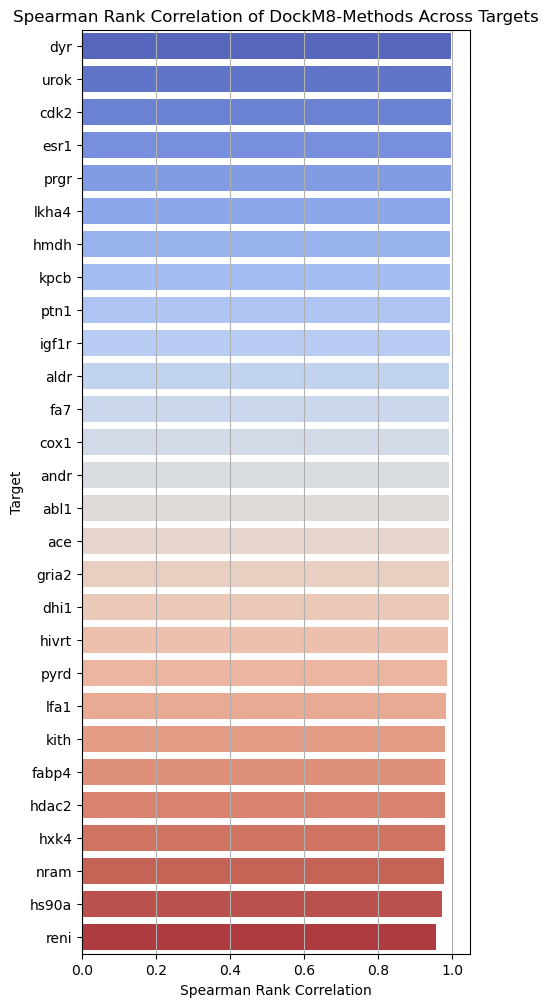

In [20]:
import pandas as pd
from scipy.stats import spearmanr

# Load the enrichment factor data
ef_30_path = "/home/alacournola/DUD-E/DUD-E_RESULTS/results_dockm8_EF_1%_30.csv"
ef_full_path = "/home/alacournola/DUD-E/DUD-E_RESULTS/results_dockm8_EF_1%.csv"

ef_30_df = pd.read_csv(ef_30_path)
ef_full_df = pd.read_csv(ef_full_path)

# Assuming the first three columns are 'clustering', 'consensus', and 'scoring', and the rest are targets
targets = ef_30_df.columns[3:]

# Store Spearman correlations
spearman_correlations_30 = {}

for target in targets:
    # Rank the methods based on their EF values for this target
    ef_30_df["rank_30"] = ef_30_df[target].rank(method="average", ascending=False)
    ef_full_df["rank_full"] = ef_full_df[target].rank(method="average", ascending=False)

    # Merge the ranks based on the method description (assuming a consistent unique identifier exists)
    merged_ranks = pd.merge(
        ef_30_df[["clustering", "consensus", "scoring", "rank_30"]],
        ef_full_df[["clustering", "consensus", "scoring", "rank_full"]],
        on=["clustering", "consensus", "scoring"],
    )

    # Calculate Spearman's rank correlation for this target
    spearman_corr, _ = spearmanr(merged_ranks["rank_30"], merged_ranks["rank_full"])
    spearman_correlations_30[target] = spearman_corr

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spearman correlations dictionary to a DataFrame for easier plotting
spearman_df_30 = pd.DataFrame(list(spearman_correlations_30.items()), columns=["Target", "Spearman Correlation"])

# Sort the DataFrame by Spearman Correlation for a more informative plot
spearman_df_30 = spearman_df_30.sort_values(by="Spearman Correlation", ascending=False)

# Create a bar plot
plt.figure(figsize=(5, 12))
sns.barplot(x="Spearman Correlation", y="Target", data=spearman_df_30, palette="coolwarm")
plt.title("Spearman Rank Correlation of DockM8-Methods Across Targets")
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Target")
plt.grid(axis="x")

# Show the plot
plt.show()

lit-pcba

split

In [21]:
import os
from rdkit.Chem import PandasTools
from sklearn.model_selection import train_test_split

directory = "/home/alacournola/Lit-PCBA"
sdf_files = []

# Walk through the directory to find all SDF files
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith("docking_library.sdf"):  # Ensures it's an SDF file
            sdf_files.append(os.path.join(root, file))

# Load each SDF file, split into training and test sets, and write them back as SDF files
for sdf_file in sdf_files:
    dataframe = PandasTools.LoadSDF(sdf_file, idName="ID", molColName="Molecule")
    dataframe["Activity"] = dataframe["Activity"].astype(float).astype(int)

    train_df_50, test_df_50 = train_test_split(
        dataframe, test_size=0.5, stratify=dataframe["Activity"], random_state=42
    )
    train_df_30, test_df_70 = train_test_split(
        dataframe, test_size=0.3, stratify=dataframe["Activity"], random_state=42
    )
    # Define the file paths for the train and test SDF files
    train_file_path_50 = os.path.join(os.path.dirname(sdf_file), "train_50.sdf")
    test_file_path_50 = os.path.join(os.path.dirname(sdf_file), "test_50.sdf")
    train_file_path_30 = os.path.join(os.path.dirname(sdf_file), "train_30.sdf")
    test_file_path_70 = os.path.join(os.path.dirname(sdf_file), "test_70.sdf")
    # Write the training and testing DataFrames to SDF files
    PandasTools.WriteSDF(
        train_df_50, train_file_path_50, molColName="Molecule", idName="ID", properties=list(train_df_50.columns)
    )
    PandasTools.WriteSDF(
        test_df_50, test_file_path_50, molColName="Molecule", idName="ID", properties=list(test_df_50.columns)
    )
    PandasTools.WriteSDF(
        train_df_30, train_file_path_30, molColName="Molecule", idName="ID", properties=list(train_df_30.columns)
    )
    PandasTools.WriteSDF(
        test_df_70, test_file_path_70, molColName="Molecule", idName="ID", properties=list(test_df_70.columns)
    )
    print(f"Written training set to {train_file_path_50}")
    print(f"Written test set to {test_file_path_50}")

Written training set to /home/alacournola/Lit-PCBA/tp53/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/tp53/test_50.sdf
Written training set to /home/alacournola/Lit-PCBA/pparg/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/pparg/test_50.sdf
Written training set to /home/alacournola/Lit-PCBA/mapk1/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/mapk1/test_50.sdf
Written training set to /home/alacournola/Lit-PCBA/pkm2/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/pkm2/test_50.sdf
Written training set to /home/alacournola/Lit-PCBA/esr1a/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/esr1a/test_50.sdf
Written training set to /home/alacournola/Lit-PCBA/esr1t/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/esr1t/test_50.sdf
Written training set to /home/alacournola/Lit-PCBA/mtorc1/train_50.sdf
Written test set to /home/alacournola/Lit-PCBA/mtorc1/test_50.sdf


50

In [22]:
from scripts.library_preparation import *
from scripts.utilities import *
from scripts.docking_functions import *
from scripts.clustering_functions import *
from scripts.rescoring_functions import *
from scripts.consensus_methods import *
from scripts.performance_calculation import *
from scripts.dogsitescorer import *
from scripts.get_pocket import *
from scripts.postprocessing import *
from scripts.protein_preparation import *

In [23]:
def calculate_performance(w_dir: Path, actives_library: Path, percentages: list):
    """
    Calculates the performance of a scoring system for different clustering methods.

    Args:
        w_dir (Path): The directory path where the scoring results are stored.
        actives_library (Path): The path to the actives library in SDF format.
        percentages (list): A list of percentages for calculating the EF (enrichment factor).

    Returns:
        DataFrame: A DataFrame containing the performance results for different clustering methods, consensus methods, and scoring functions.
    """
    printlog("Calculating performance...")
    # all_results = pd.DataFrame(columns=['clustering', 'consensus', 'scoring'] + [f'EF{p}' for p in percentages])
    # Load actives data
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName="ID")
    actives_df = actives_df[["ID", "Activity"]]
    actives_df["Activity"] = pd.to_numeric(actives_df["Activity"])
    # Calculate performance for each clustering method
    dirs = [dir for dir in os.listdir(w_dir) if dir.startswith("rescoring") and dir.endswith("clustered")]
    results = parallel_executor(
        calculate_performance_for_clustering_method,
        dirs,
        ncpus=math.ceil(len(dirs) // 2),
        backend="concurrent_process_silent",
        w_dir=w_dir,
        actives_df=actives_df,
        percentages=percentages,
    )
    all_results = pd.concat(results, ignore_index=True)
    (w_dir / "performance").mkdir(parents=True, exist_ok=True)
    all_results.to_csv(Path(w_dir) / "performance" / "performance_50.csv", index=False)
    return all_results

In [24]:
def determine_performance(target_dir):
    # for target_dir in tqdm(sorted(os.listdir('/home/alacournola/DEKOIS_2.0x'))):
    try:
        calculate_performance(
            Path(f"/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss"),
            f"/home/alacournola/Lit-PCBA/{target_dir}/train_50.sdf",
            [0.5, 1, 5],
        )
    except:
        print(target_dir, "FAILED")
        print(traceback.format_exc())


dirs = [dir for dir in sorted(os.listdir("/home/alacournola/Lit-PCBA"))]

parallel_executor(determine_performance, dirs, ncpus=4, backend="concurrent_process_silent")

[2024-Feb-17 01:27:44]: Calculating performance...
[2024-Feb-17 01:27:44]: Calculating performance...
[2024-Feb-17 01:27:44]: Calculating performance...
[2024-Feb-17 01:27:44]: Calculating performance...




LIT-PCBA_RESULTS FAILED
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/3666872644.py", line 4, in determine_performance
    calculate_performance(Path(f'/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss'), f'/home/alacournola/Lit-PCBA/{target_dir}/train_50.sdf', [0.5, 1, 5])
  File "/tmp/ipykernel_1520428/1137044451.py", line 16, in calculate_performance
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName='ID')
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/rdkit/Chem/PandasTools.py", line 248, in LoadSDF
    f = open(filename, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/train_50.sdf'

[2024-Feb-17 01:27:44]: Calculating perform

ConvexPLR: 100%|██████████| 9/9 [01:55<00:00, 12.82s/it]6s/it]


[2024-Feb-17 01:34:11]: Calculating performance...



ConvexPLR: 100%|██████████| 9/9 [01:59<00:00, 13.28s/it]9s/it]


[2024-Feb-17 01:34:36]: Calculating performance...



ConvexPLR: 100%|██████████| 9/9 [02:09<00:00, 14.38s/it]s/it]


[2024-Feb-17 01:41:31]: Calculating performance...



bestpose: 100%|██████████| 9/9 [51:47<00:00, 345.23s/it]


[None, None, None, None, None, None, None, None]

In [25]:
import os
import pandas as pd
from tqdm import tqdm
import traceback

data = pd.DataFrame(columns=["pdb_id", "model", "AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"])

for target_dir in tqdm(os.listdir("/home/alacournola/Lit-PCBA/")):
    try:
        performance = pd.read_csv(
            f"/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss/performance/performance_50.csv"
        )

        # Extract relevant data
        pdb_id = target_dir
        model = "DockM8-max"
        performance = performance.sort_values(by="AUC_ROC", ascending=False)
        auc_roc = performance.iloc[0]["AUC_ROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="BEDROC", ascending=False)
        bedroc = performance.iloc[0]["BEDROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="AUC", ascending=False)
        auc = performance.iloc[0]["AUC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="RIE", ascending=False)
        rie = performance.iloc[0]["RIE"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_0.5%", ascending=False)
        ef_05 = performance.iloc[0]["EF_0.5%"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_1%", ascending=False)
        ef_1 = performance.iloc[0]["EF_1%"] if len(performance) > 0 else None
        best_model_clustering = performance.iloc[0]["clustering"] if len(performance) > 0 else None
        best_model_consensus = performance.iloc[0]["consensus"] if len(performance) > 0 else None
        best_model_scoring = performance.iloc[0]["scoring"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_5%", ascending=False)
        ef_5 = performance.iloc[0]["EF_5%"] if len(performance) > 0 else None

        extracted_data = pd.DataFrame(
            [
                {
                    "pdb_id": target_dir,
                    "model": "DockM8-max",
                    "AUC_ROC": round(auc_roc, 3),
                    "BEDROC": round(bedroc, 3),
                    "AUC": round(auc, 3),
                    "RIE": round(rie, 3),
                    "EF_0.5%": round(ef_05, 3),
                    "EF_1%": round(ef_1, 3),
                    "EF_5%": round(ef_5, 3),
                    "best_clustering_EF1": best_model_clustering,
                    "best_consensus_EF1": best_model_consensus,
                    "best_scoring_EF1": best_model_scoring,
                }
            ]
        )

        data = pd.concat([data, extracted_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing {target_dir}: {e}")
        print(traceback.format_exc())
# Optionally, you can reset the index of the DataFrame
data = data.reset_index(drop=True)

display(data)

data.to_csv("/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/results_dockm8_max_50.csv", index=False)

 88%|████████▊ | 7/8 [00:01<00:00,  7.86it/s]

Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_50.csv'
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/4285520497.py", line 10, in <module>
    performance = pd.read_csv(f'/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss/performance/performance_50.csv')
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 948, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 611, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1448, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/p

100%|██████████| 8/8 [00:01<00:00,  6.66it/s]


,pdb_id,model,AUC_ROC,BEDROC,AUC,RIE,EF_0.5%,EF_1%,EF_5%,best_clustering_EF1,best_consensus_EF1,best_scoring_EF1
0,tp53,DockM8-max,0.986,0.626,0.986,26.305,34.62,33.68,18.99,LinF9,avg_ECR,CHEMPLP_ConvexPLR
1,pparg,DockM8-max,0.996,0.806,0.996,52.056,100.00,70.26,19.99,bestpose_PLANTS,avg_ECR,ConvexPLR_CNN-Score
2,mapk1,DockM8-max,0.992,0.619,0.992,41.217,65.08,53.19,20.01,ConvexPLR,avg_ECR,KORP-PL_GNINA-Affinity
3,pkm2,DockM8-max,0.992,0.567,0.992,41.786,51.28,48.35,20.00,bestpose,avg_ECR,CNN-Score_LinF9
4,esr1a,DockM8-max,0.992,0.576,0.992,42.558,66.62,66.62,19.99,KORP-PL,avg_ECR,RFScoreVS_KORP-PL
5,esr1t,DockM8-max,0.985,0.659,0.985,26.193,49.51,35.65,17.68,LinF9,avg_ECR,CNN-Score_RTMScore
6,mtorc1,DockM8-max,0.990,0.512,0.990,36.776,37.39,39.66,19.99,bestpose_SMINA,avg_ECR,CNN-Score_RTMScore


In [26]:
from tqdm import tqdm
import os
import pandas as pd
import traceback

metrics = ["AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"]
base_dir = "/home/alacournola/Lit-PCBA"


# for metric in tqdm(metrics):
def process_metric(metric):
    final = None
    for target_dir in sorted(os.listdir(base_dir)):
        file_path = os.path.join(base_dir, f"{target_dir}/{target_dir}_p_protoss/performance/performance_50.csv")
        try:
            with open(file_path, "r") as file:
                performance = pd.read_csv(file)
                performance = performance.sort_values(by=metric, ascending=False)
                performance = performance[["clustering", "consensus", "scoring", metric]]
                performance[metric] = performance[metric].round(3)
                performance = performance.rename(columns={metric: target_dir})
                if final is None:
                    final = performance
                else:
                    final = pd.merge(final, performance, on=["clustering", "consensus", "scoring"], how="outer")
        except Exception as e:
            print(f"Error processing {target_dir}: {e}")
            traceback.print_exc()

    if final is not None:
        final.to_csv(os.path.join(base_dir, "LIT-PCBA_RESULTS", f"results_dockm8_{metric}_50.csv"), index=False)


parallel_executor(process_metric, metrics, 8)

Running <function process_metric at 0x7f5d7a353c70>:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_50.csv'
Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_50.csv'
Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_50.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_50.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_50.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PC

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/176920087.py", line 15, in process_metric
    with o

[None, None, None, None, None, None, None]

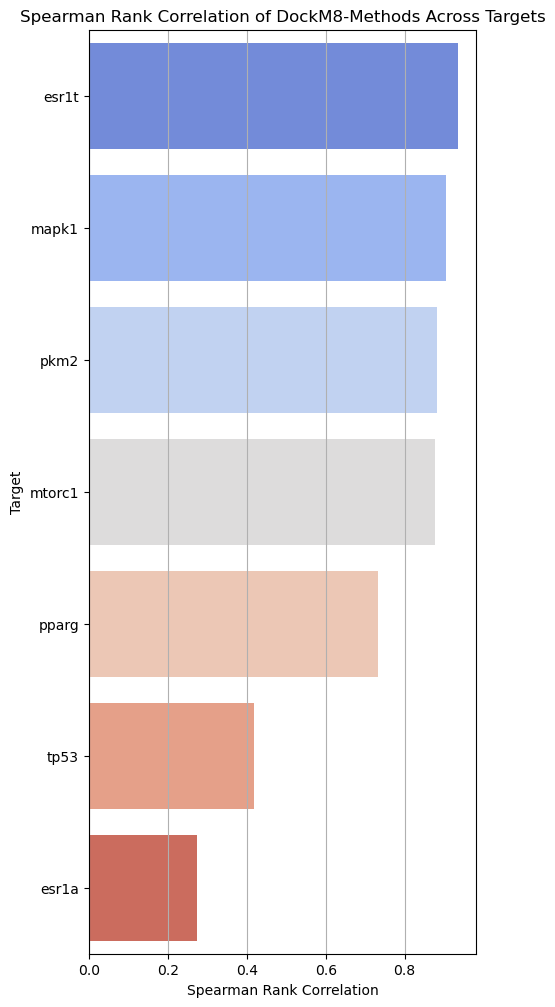

In [27]:
import pandas as pd
from scipy.stats import spearmanr

# Load the enrichment factor data
ef_50_path = "/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/results_dockm8_EF_1%_50.csv"
ef_full_path = "/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/results_dockm8_EF_1%.csv"

ef_50_df = pd.read_csv(ef_50_path)
ef_full_df = pd.read_csv(ef_full_path)

# Assuming the first three columns are 'clustering', 'consensus', and 'scoring', and the rest are targets
targets = ef_50_df.columns[3:]

# Store Spearman correlations
spearman_correlations_50 = {}

for target in targets:
    # Rank the methods based on their EF values for this target
    ef_50_df["rank_50"] = ef_50_df[target].rank(method="average", ascending=False)
    ef_full_df["rank_full"] = ef_full_df[target].rank(method="average", ascending=False)

    # Merge the ranks based on the method description (assuming a consistent unique identifier exists)
    merged_ranks = pd.merge(
        ef_50_df[["clustering", "consensus", "scoring", "rank_50"]],
        ef_full_df[["clustering", "consensus", "scoring", "rank_full"]],
        on=["clustering", "consensus", "scoring"],
    )

    # Calculate Spearman's rank correlation for this target
    spearman_corr, _ = spearmanr(merged_ranks["rank_50"], merged_ranks["rank_full"])
    spearman_correlations_50[target] = spearman_corr

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spearman correlations dictionary to a DataFrame for easier plotting
spearman_df_50 = pd.DataFrame(list(spearman_correlations_50.items()), columns=["Target", "Spearman Correlation"])

# Sort the DataFrame by Spearman Correlation for a more informative plot
spearman_df_50 = spearman_df_50.sort_values(by="Spearman Correlation", ascending=False)

# Create a bar plot
plt.figure(figsize=(5, 12))
sns.barplot(x="Spearman Correlation", y="Target", data=spearman_df_50, palette="coolwarm")
plt.title("Spearman Rank Correlation of DockM8-Methods Across Targets")
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Target")
plt.grid(axis="x")

# Show the plot
plt.show()

30

In [28]:
def calculate_performance(w_dir: Path, actives_library: Path, percentages: list):
    """
    Calculates the performance of a scoring system for different clustering methods.

    Args:
        w_dir (Path): The directory path where the scoring results are stored.
        actives_library (Path): The path to the actives library in SDF format.
        percentages (list): A list of percentages for calculating the EF (enrichment factor).

    Returns:
        DataFrame: A DataFrame containing the performance results for different clustering methods, consensus methods, and scoring functions.
    """
    printlog("Calculating performance...")
    # all_results = pd.DataFrame(columns=['clustering', 'consensus', 'scoring'] + [f'EF{p}' for p in percentages])
    # Load actives data
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName="ID")
    actives_df = actives_df[["ID", "Activity"]]
    actives_df["Activity"] = pd.to_numeric(actives_df["Activity"])
    # Calculate performance for each clustering method
    dirs = [dir for dir in os.listdir(w_dir) if dir.startswith("rescoring") and dir.endswith("clustered")]
    results = parallel_executor(
        calculate_performance_for_clustering_method,
        dirs,
        ncpus=math.ceil(len(dirs) // 2),
        backend="concurrent_process_silent",
        w_dir=w_dir,
        actives_df=actives_df,
        percentages=percentages,
    )
    all_results = pd.concat(results, ignore_index=True)
    (w_dir / "performance").mkdir(parents=True, exist_ok=True)
    all_results.to_csv(Path(w_dir) / "performance" / "performance_30.csv", index=False)
    return all_results

In [29]:
def determine_performance(target_dir):
    # for target_dir in tqdm(sorted(os.listdir('/home/alacournola/DEKOIS_2.0x'))):
    try:
        calculate_performance(
            Path(f"/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss"),
            f"/home/alacournola/Lit-PCBA/{target_dir}/train_30.sdf",
            [0.5, 1, 5],
        )
    except:
        print(target_dir, "FAILED")
        print(traceback.format_exc())


dirs = [dir for dir in sorted(os.listdir("/home/alacournola/Lit-PCBA"))]

parallel_executor(determine_performance, dirs, ncpus=4, backend="concurrent_process_silent")

[2024-Feb-17 02:49:26]: Calculating performance...
[2024-Feb-17 02:49:26]: Calculating performance...
[2024-Feb-17 02:49:26]: Calculating performance...
[2024-Feb-17 02:49:26]: Calculating performance...




LIT-PCBA_RESULTS FAILED
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/515516805.py", line 4, in determine_performance
    calculate_performance(Path(f'/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss'), f'/home/alacournola/Lit-PCBA/{target_dir}/train_30.sdf', [0.5, 1, 5])
  File "/tmp/ipykernel_1520428/803586927.py", line 16, in calculate_performance
    actives_df = PandasTools.LoadSDF(str(actives_library), molColName=None, idName='ID')
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/rdkit/Chem/PandasTools.py", line 248, in LoadSDF
    f = open(filename, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/train_30.sdf'

[2024-Feb-17 02:49:26]: Calculating performan

bestpose_SMINA:  44%|████▍     | 4/9 [01:51<02:37, 31.51s/it]

[2024-Feb-17 02:55:54]: Calculating performance...

[2024-Feb-17 02:55:54]: Calculating performance...



ConvexPLR: 100%|██████████| 9/9 [02:00<00:00, 13.43s/it]s/it]


[2024-Feb-17 03:02:10]: Calculating performance...



bestpose: 100%|██████████| 9/9 [53:56<00:00, 359.63s/it]


[None, None, None, None, None, None, None, None]

In [30]:
import os
import pandas as pd
from tqdm import tqdm
import traceback

data = pd.DataFrame(columns=["pdb_id", "model", "AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"])

for target_dir in tqdm(os.listdir("/home/alacournola/Lit-PCBA/")):
    try:
        performance = pd.read_csv(
            f"/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss/performance/performance_30.csv"
        )

        # Extract relevant data
        pdb_id = target_dir
        model = "DockM8-max"
        performance = performance.sort_values(by="AUC_ROC", ascending=False)
        auc_roc = performance.iloc[0]["AUC_ROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="BEDROC", ascending=False)
        bedroc = performance.iloc[0]["BEDROC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="AUC", ascending=False)
        auc = performance.iloc[0]["AUC"] if len(performance) > 0 else None
        performance = performance.sort_values(by="RIE", ascending=False)
        rie = performance.iloc[0]["RIE"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_0.5%", ascending=False)
        ef_05 = performance.iloc[0]["EF_0.5%"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_1%", ascending=False)
        ef_1 = performance.iloc[0]["EF_1%"] if len(performance) > 0 else None
        best_model_clustering = performance.iloc[0]["clustering"] if len(performance) > 0 else None
        best_model_consensus = performance.iloc[0]["consensus"] if len(performance) > 0 else None
        best_model_scoring = performance.iloc[0]["scoring"] if len(performance) > 0 else None
        performance = performance.sort_values(by="EF_5%", ascending=False)
        ef_5 = performance.iloc[0]["EF_5%"] if len(performance) > 0 else None

        extracted_data = pd.DataFrame(
            [
                {
                    "pdb_id": target_dir,
                    "model": "DockM8-max",
                    "AUC_ROC": round(auc_roc, 3),
                    "BEDROC": round(bedroc, 3),
                    "AUC": round(auc, 3),
                    "RIE": round(rie, 3),
                    "EF_0.5%": round(ef_05, 3),
                    "EF_1%": round(ef_1, 3),
                    "EF_5%": round(ef_5, 3),
                    "best_clustering_EF1": best_model_clustering,
                    "best_consensus_EF1": best_model_consensus,
                    "best_scoring_EF1": best_model_scoring,
                }
            ]
        )

        data = pd.concat([data, extracted_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing {target_dir}: {e}")
        print(traceback.format_exc())
# Optionally, you can reset the index of the DataFrame
data = data.reset_index(drop=True)

display(data)

data.to_csv("/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/results_dockm8_max_30.csv", index=False)

 88%|████████▊ | 7/8 [00:00<00:00,  8.76it/s]

Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_30.csv'
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/3893325625.py", line 10, in <module>
    performance = pd.read_csv(f'/home/alacournola/Lit-PCBA/{target_dir}/{target_dir}_p_protoss/performance/performance_30.csv')
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 948, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 611, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1448, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/p

100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


,pdb_id,model,AUC_ROC,BEDROC,AUC,RIE,EF_0.5%,EF_1%,EF_5%,best_clustering_EF1,best_consensus_EF1,best_scoring_EF1
0,tp53,DockM8-max,0.984,0.596,0.984,24.789,36.01,32.20,17.76,bestpose_PLANTS,avg_ECR,CNN-Score_RTMScore
1,pparg,DockM8-max,0.995,0.763,0.995,49.632,100.00,67.62,20.03,bestpose_PLANTS,avg_ECR,ConvexPLR_CNN-Score
2,mapk1,DockM8-max,0.992,0.614,0.992,40.865,61.18,51.33,20.00,ConvexPLR,avg_ECR,KORP-PL_GNINA-Affinity
3,pkm2,DockM8-max,0.992,0.583,0.992,42.999,56.02,48.43,20.00,bestpose,avg_ECR,CNN-Score_GNINA-Affinity
4,esr1a,DockM8-max,0.993,0.628,0.993,46.125,90.86,66.96,20.00,KORP-PL,avg_ECR,RFScoreVS_KORP-PL
5,esr1t,DockM8-max,0.985,0.649,0.985,25.895,47.02,35.56,17.72,LinF9,avg_ECR,CNN-Score_Vinardo
6,mtorc1,DockM8-max,0.991,0.528,0.991,37.872,41.08,38.31,20.01,ConvexPLR,avg_ECR,RFScoreVS_CNN-Score


In [31]:
from tqdm import tqdm
import os
import pandas as pd
import traceback

metrics = ["AUC_ROC", "BEDROC", "AUC", "RIE", "EF_0.5%", "EF_1%", "EF_5%"]
base_dir = "/home/alacournola/Lit-PCBA"


# for metric in tqdm(metrics):
def process_metric(metric):
    final = None
    for target_dir in sorted(os.listdir(base_dir)):
        file_path = os.path.join(base_dir, f"{target_dir}/{target_dir}_p_protoss/performance/performance_30.csv")
        try:
            with open(file_path, "r") as file:
                performance = pd.read_csv(file)
                performance = performance.sort_values(by=metric, ascending=False)
                performance = performance[["clustering", "consensus", "scoring", metric]]
                performance[metric] = performance[metric].round(3)
                performance = performance.rename(columns={metric: target_dir})
                if final is None:
                    final = performance
                else:
                    final = pd.merge(final, performance, on=["clustering", "consensus", "scoring"], how="outer")
        except Exception as e:
            print(f"Error processing {target_dir}: {e}")
            traceback.print_exc()

    if final is not None:
        final.to_csv(os.path.join(base_dir, "LIT-PCBA_RESULTS", f"results_dockm8_{metric}_30.csv"), index=False)


parallel_executor(process_metric, metrics, 8)

Running <function process_metric at 0x7f5d7a46aa70>:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_30.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_30.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_30.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_30.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA_RESULTS_p_protoss/performance/performance_30.csv'Error processing LIT-PCBA_RESULTS: [Errno 2] No such file or directory: '/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/LIT-PCBA

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_1520428/1700369193.py", line 15, in process_metric
    with open(file_path, 'r') as file:


  File "/tmp/ipykernel_1520428/1700369193.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/1700369193.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/1700369193.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/1700369193.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/tmp/ipykernel_1520428/1700369193.py", line 15, in process_metric
    with open(file_path, 'r') as file:
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 310, in _modified_open
    return io_open(file, *args, **kwargs)
  File "/home/alacournola/anaconda3/envs/dockm8/lib/python3.10/site-pac

[None, None, None, None, None, None, None]

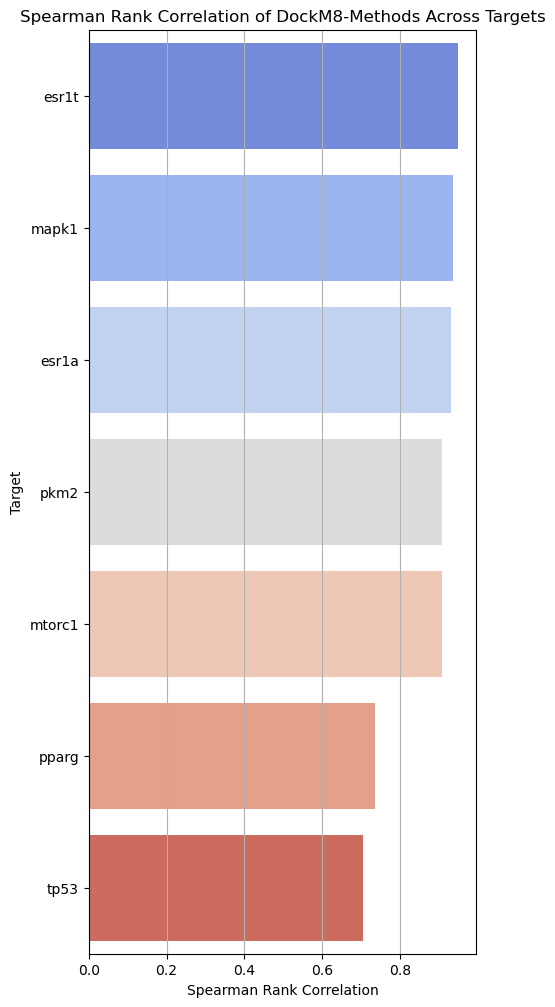

In [32]:
import pandas as pd
from scipy.stats import spearmanr

# Load the enrichment factor data
ef_30_path = "/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/results_dockm8_EF_1%_30.csv"
ef_full_path = "/home/alacournola/Lit-PCBA/LIT-PCBA_RESULTS/results_dockm8_EF_1%.csv"

ef_30_df = pd.read_csv(ef_30_path)
ef_full_df = pd.read_csv(ef_full_path)

# Assuming the first three columns are 'clustering', 'consensus', and 'scoring', and the rest are targets
targets = ef_30_df.columns[3:]

# Store Spearman correlations
spearman_correlations_30 = {}

for target in targets:
    # Rank the methods based on their EF values for this target
    ef_30_df["rank_30"] = ef_30_df[target].rank(method="average", ascending=False)
    ef_full_df["rank_full"] = ef_full_df[target].rank(method="average", ascending=False)

    # Merge the ranks based on the method description (assuming a consistent unique identifier exists)
    merged_ranks = pd.merge(
        ef_30_df[["clustering", "consensus", "scoring", "rank_30"]],
        ef_full_df[["clustering", "consensus", "scoring", "rank_full"]],
        on=["clustering", "consensus", "scoring"],
    )

    # Calculate Spearman's rank correlation for this target
    spearman_corr, _ = spearmanr(merged_ranks["rank_30"], merged_ranks["rank_full"])
    spearman_correlations_30[target] = spearman_corr

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spearman correlations dictionary to a DataFrame for easier plotting
spearman_df_30 = pd.DataFrame(list(spearman_correlations_30.items()), columns=["Target", "Spearman Correlation"])

# Sort the DataFrame by Spearman Correlation for a more informative plot
spearman_df_30 = spearman_df_30.sort_values(by="Spearman Correlation", ascending=False)

# Create a bar plot
plt.figure(figsize=(5, 12))
sns.barplot(x="Spearman Correlation", y="Target", data=spearman_df_30, palette="coolwarm")
plt.title("Spearman Rank Correlation of DockM8-Methods Across Targets")
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Target")
plt.grid(axis="x")

# Show the plot
plt.show()